<a href="https://colab.research.google.com/github/EduardoPach/Chemical_Engineering/blob/main/PFR_Model_and_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from IPython import display

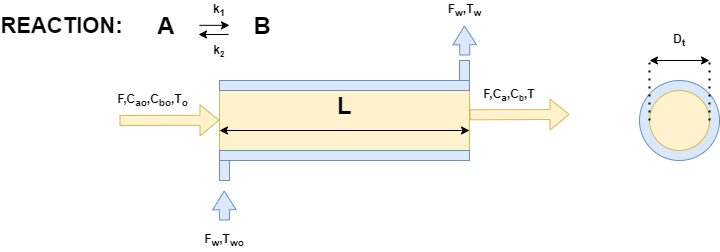

# Modelagem:

## Considerações:


1. Nível do PFR e da Camisa são constantes.
2. Variação na temperatura da água da camisa é desprezível.
3. Concentração dos componentes variam apenas na direção axial do reator.
4. Variação na massa específica do fluido é desprezível.
5. Resistência condutiva desprezível para troca de calor.
6. Calor específico constante.
7. Mistura perfeita nos discos.


## Balanços:

Como este problema é classificado como parâmetros distribuidos (dependência não só temporal,mas também espacial no volume de controle) faz-se a concentração de parâmetros dividindo o volume de controle em N cortes de modo a retirar a dependência espacial e transformar um problema de EDP (equação diferencial parcial) para uma sistema de N EDO's (equações diferencias ordinárias). O número de divisões escolhidos definirá o quão fiel será o perfil dos estados obtidos para o volume de controle (PFR).

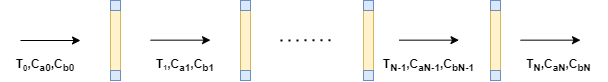

Como o nível do PFR e da camisa são constantes e a temperatura da água da camisa é considerado constante não é necessário realizar os balanços de massa global para o PFR e camisa nem balanço de energia para camisa. Portanto, deve-se apenas realizar os **balanços de massa para os componentes** A e B, assim como o **balanço de energia para o PFR**.

### B.M.Ca:

\begin{align*}
\frac{dV_DC_{a,i}}{dt} &= F(C_{a,i-1}-C_{a,i})+(k_{2,i}C_{b,i}-k_{1,i}C_{a,i})V_D \\
\frac{dC_{a,i}}{dt} &= \frac{F}{V_D}(C_{a,i-1}-C_{a,i})+k_{2,i}C_{b,i}-k_{1,i}C_{a,i}
\end{align*}

### B.M.Cb:

\begin{align*}
\frac{dV_DC_{b,i}}{dt} &= F(C_{b,i-1}-C_{b,i})+(k_{1,i}C_{a,i}-k_{2,i}C_{b,i})V_D \\
\frac{dC_{b,i}}{dt} &= \frac{F}{V_D}(C_{b,i-1}+C_{b,i})+k_{1,i}C_{a,i}-k_{2,i}C_{b,i}
\end{align*}

### B.E:

\begin{align*}
\rho C_p V_D \frac{dT_i}{dt} &= F \rho C_p (T_{i-1}-T_i)+((-\Delta H_r)k_iC_{ai}+(-\Delta H_{r,2})k_{2,i}C_{ai})V_D-UA(T_i-T_w)\\
\frac{dT_i}{dt} &= \frac{F}{V_D}(T_{i-1}-T_i)+\frac{(-\Delta H_{r,1})k_{1,i}C_{ai}+(-\Delta H_{r,2})k_{2,i}C_{ai}}{\rho C_p} - \frac{UA(T_i-T_w)}{\rho C_p V_D}
\end{align*}

### Equações Finais:

\begin{align*}\label{eq:k}
\frac{dC_{a,i}}{dt} &= \frac{F}{V_D}(C_{a,i-1}-C_{a,i})+k_{2,i}C_{b,i}-k_{1,i}C_{a,i}\quad &C_a^o=2 ,\quad i=1,2,...,N\\
\frac{dC_{b,i}}{dt} &= \frac{F}{V_D}(C_{b,i-1}+C_{b,i})+k_{1,i}C_{a,i}-k_{2,i}C_{b,i}\quad &C_b^o=0.1 ,\quad i=1,2,...,N\\
\frac{dT_i}{dt} &= \frac{F}{V_D}(T_{i-1}-T_i)+\frac{(-\Delta H_{r,1})k_{1,i}C_{ai}+(-\Delta H_{r,2})k_{2,i}C_{ai}}{\rho C_p} - \frac{UA(T_i-T_w)}{\rho C_p V_D}\quad &T^o=300 ,\quad i=1,2,...,N\\
k_{1,i} &= k_{o,1}\exp\left(-\frac{E_{a,1}}{RT_i}\right) \quad &i=1,2,...,N \\
k_{2,i} &= k_{o,2}\exp\left(-\frac{E_{a,2}}{RT_i}\right) \quad &i=1,2,...,N
\end{align*}



### Tabela de Variáveis:

| Variável | Símbolo | Valor | Unidade | Comentário |
| :------- | :----: | :---: | :---- | |
| Energia de Ativação Direta | $E_{a,1}$ | 10000 | J/mol | |
| Energia de Ativação Inversa | $E_{a,2}$ | 10000 | J/mol | |
| Fator pré-Exponencial de Arrhenius Direto | $k_{o,1}$ | 0.5 | 1/s | |
| Fator pré-Exponencial de Arrhenius Direto | $k_{o,1}$ | 1 | 1/s | |
| Entalpia de Reação Direta | $\Delta H_{r,1}$ | -10000 | J/mol | |
| Entalpia de Reação Inversa | $\Delta H_{r,2}$ | 8000 | J/mol | |
| Constante dos Gases | $R$ | 8.314 | J/mol/K | |
| Volume do Reator | $V$ | 2 | m³ | |
| Massa Específica | $\rho$ | 1000 | kg/m³ | |
| Calor Específico | $C_p$ | 4000 | J/kg/K | |
| Coeficiente de Troca Térmica | $UA$ | 1000 | J/s/K | |
| Vazão Volumétrica | $F$ | 10 | m³/h | |
| Concentração de Alimentação de A | $C_{a,f}$ | 3 | kmol/m³ | |
| Concentração de Alimentação de b | $C_{b,f}$ | 0 | kmol/m³ | |
| Temperatura de Alimentação | $T_f$ | 350 | K | |
| Temperatura A.R | $T_w$ | 300 | K |  |


In [ ]:
# Variáveis necessárias para calcular o T,Ca e Cb
Ea1 = 10000
Ea2 = 10000
ko1 = 0.5
ko2 = 1
Hr1 = -10000
Hr2 = 8000
R = 8.314
rho = 1000
V = 2
Cp = 4000
UA = 1000
F = 10/3600 
Ca_t0 = 2 # Estado inicial do PFR para Ca (valor nos volumes)
Cb_t0 = 0.1 # Estado inicial do PFR para Cb (valor nos volumes)
T_t0 = 300 # Estado Inicial do PFR para T (valor nos volumes)
Tw = 300
Caf = 3 
Cbf = 0
Tf = 273
n = 50
Vd = V/n
Cao = [Caf if i == 0 else Ca_t0 for i in range(n+1)]
Cbo = [Cbf if i == 0 else Cb_t0 for i in range(n+1)]
To  = [Tf if i == 0 else T_t0 for i in range(n+1)]
t = np.linspace(0,2000,201)

In [ ]:
def k1(T):
    return ko1*np.exp(-Ea1/R/T)

def k2(T):
    return ko2*np.exp(-Ea2/R/T)

def PFR(y,t,Ca_in,Cb_in,T_in):
    Ca,Cb,T = y

    dCadt = F/Vd*(Ca_in-Ca)-k1(T)*Ca+k2(T)*Cb
    dCbdt = F/Vd*(Cb_in-Cb)+k1(T)*Ca-k2(T)*Cb
    dTdt = F/Vd*(T_in-T)+((-Hr1)*k1(T)*Ca+(-Hr2)*k2(T)*Cb)/(rho*Cp)-UA*(T-Tw)/rho/Cp/Vd
    
    return [dCadt,dCbdt,dTdt]


In [ ]:
# Criando Matriz com valores iniciais e de alimentação
Y = np.ones((len(t),n+1,3))
#  Alocando valores dos perfis para t=0
Y[0,:,0] = Cao
Y[0,:,1] = Cbo
Y[0,:,2] = To
# Alocando valores da corrente de alimentação para todos os t
feed = [Ca_t0,Cb_t0,T_t0]
feed_array = np.array(feed)
feed_matrix = np.array([])
# Ajeitando dimensões para alocar valores de alimentação ao longo do tempo
for i in range(len(t)):
    feed_matrix = np.hstack((feed_matrix,feed_array))
    
feed_matrix = feed_matrix.reshape(len(t),3)
    
Y[:,0,0:3] = feed_matrix

# Iterando por timestep descontando t=0
for i in range(len(t)-1):
    # Iterando entre volumes começando por 1, pois tempos N+1 valores para os estados
    for j in range(1,n+1):
        # Valores inicias: Valor atual do volume que está sendo calculado na Matriz.
        Cao = Y[i,j,0] 
        Cbo = Y[i,j,1]
        To = Y[i,j,2]
        y0 = [Cao,Cbo,To]
        # Valores de entrada no volume
        Ca_in = Y[i,j-1,0]
        Cb_in = Y[i,j-1,1]
        T_in  = Y[i,j-1,2]
        inputs = (Ca_in,Cb_in,T_in)
        # timestep
        ts = [t[i],t[i+1]]
        # Resolvendo sistema de EDO's e salvando valores calculados em Ca,Cb e T
        Ca,Cb,T = odeint(PFR,y0,ts,args=inputs)[-1] # [-1] é necessário porque odeint retorna y0 e y calc
        # Salvando valores calculados para o volume j no próximo t.
        Y[i+1,j,0] = Ca
        Y[i+1,j,1] = Cb
        Y[i+1,j,2] = T

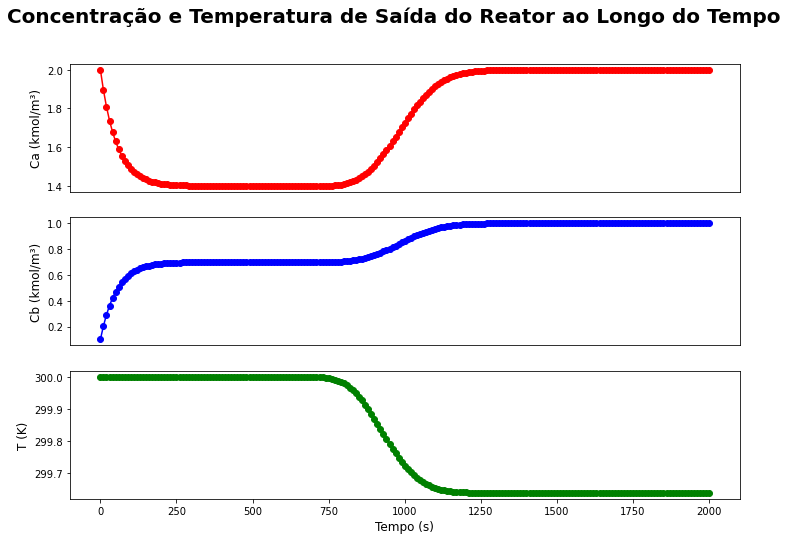

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(t,Y[:,-1,0],c='r',marker='o')
plt.ylabel("Ca (kmol/m³)",fontsize=12)
plt.xticks([])

plt.subplot(3,1,2)
plt.plot(t,Y[:,-1,1],c='b',marker='o')
plt.ylabel("Cb (kmol/m³)",fontsize=12)
plt.xticks([])

plt.subplot(3,1,3)
plt.plot(t,Y[:,-1,2],c='g',marker='o')
plt.ylabel("T (K)",fontsize=12)
plt.xlabel("Tempo (s)",fontsize=12)
plt.suptitle("Concentração e Temperatura de Saída do Reator ao Longo do Tempo",fontsize=20,fontweight="bold");

In [ ]:
Ca = Y[:,:,0]
Cb = Y[:,:,1]
T  = Y[:,:,2]

fig = plt.figure(figsize=(12,8))

ax1 = plt.subplot(3,1,1)
line1, = ax1.plot([],[],c='r',marker='o')
ax1.set_ylabel('Ca (kmol/m³)',fontsize=12)
ax1.set_ylim(np.min(Ca)-.5,np.max(Ca)+.5)
ax1.set_xlim(0,2)
ax1.set_xticks([])

ax2 = plt.subplot(3,1,2)
line2, = ax2.plot([],[],c='b',marker='o')
ax2.set_ylabel("Cb (kmol/m³)",fontsize=12)
ax2.set_ylim(np.min(Cb)-.1,np.max(Cb)+.1)
ax2.set_xticks([])
ax2.set_xlim(0,2)

ax3 = plt.subplot(3,1,3)
line3, = ax3.plot([],[],c='g',marker='o')
ax3.set_ylabel("T (K)",fontsize=12)
ax3.set_xlabel("Comprimento (m)",fontsize=12)
ax3.set_ylim(np.min(T)-5,np.max(T)+5)
ax3.set_xlim(0,2)

plt.close()

def animate(i):
    line1.set_data(np.linspace(0,2,n+1),Ca[i,:]) # Supondo PFR com comprimento de 2m
    line2.set_data(np.linspace(0,2,n+1),Cb[i,:])
    line3.set_data(np.linspace(0,2,n+1),T[i,:])
    fig.suptitle("Perfis de Concentração e Temperatura PFR - t={:.0f}s".format(t[i]),fontsize=20,fontweight='bold')

In [ ]:
anim = FuncAnimation(fig,animate,frames=len(t),interval=100)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)